# Sentiment Analysis
Author Zirui Zheng - ziruizhe

#### Table of Contents

- Pre-Processing
- Sentiment Analysis

    - Data preparation
    - Visualization
    
        1. Difference: pre-launch VS post-launch
        2. Difference: professionals VS normal users
        3. Difference: female VS male
        4. Difference: Twitter VS Non-Twitter users
        5. Difference: All sorts of post types (video, image, etc.)
        
        
    - WordCloud for good VS bad across all products
    - Time Series Forecasting

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from collections import Counter
import glob
import numpy as np
import datetime
import time
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import skimage.io
import statsmodels.api as sm
import itertools
from pylab import rcParams
import spacy
nlp = spacy.load('en')
%matplotlib inline

In [53]:
#Constant variables to use
kw_dict = {'apple iphone x':['iphone x', 'iphone 10', 'iphonex', 'iphone10'], 
           'apple iphone 8': ['iphone 8', 'iphone8', 'plus']}
lc_dates = {'apple':datetime.date(2017,9,22), 'samsung':datetime.date(2017,3,29)}
start_dates = {'apple':datetime.date(2017,9,1), 'samsung':datetime.date(2017,3,1)}
end_dates = {'apple':datetime.date(2017,11,1), 'samsung':datetime.date(2017,7,1)}
products = ['Galaxy S8','Apple','Apple iPhone X', 'Apple iPhone 8']
genders = ['Female', 'Male']

In [20]:
def clean_text(text): 
        ''' 
        Utility function to clean text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", text).split())

In [21]:
def pre_processing(df):
    #Remove duplicates
    data = df.drop_duplicates()

    #Drop na and 60% empty columns
    data = data.dropna(how='all', subset=['Sound Bite Text', 'No. of Followers/Daily Unique Visitors'])
    drop_cols=[]
    for col in df.columns:
        if df[col].isna().sum() > df.shape[0] * 0.4:
            drop_cols.append(col)

    data = data.drop(columns=drop_cols)

    #Keep only original posts
    data = data[data['Post Type'] == 'Original']

    # drop rows with review text deleted
    data = data.drop(data[(data["Sound Bite Text"] == "Post deleted by the author.")].index, inplace=False)
    
    # remove links and special characters
    for i in range(len(data)):
        data.iloc[i]['Sound Bite Text'] = clean_text(data.iloc[i]['Sound Bite Text'])

    #Convert Date
    data = data.rename(columns = {'Published Date (GMT-04:00) New York':'Date'})
    data['Date'] = pd.to_datetime(data['Date'],format="%b %d, %Y %I:%M:%S %p").dt.date
    
    return data

In [3]:
start = time.time()
paths = glob.glob('./data/*.xlsx')
df = pd.ExcelFile(paths[0]).parse(0)
for path in paths[1:]:
    tmp = pd.ExcelFile(path).parse(0)
    df = pd.concat([df, tmp], ignore_index=True)

print('Processing time: ', time.time()-start)

Processing time:  299.22499418258667


In [23]:
data = pre_processing(df)

## LDA Clustering into two groups

In [24]:
start = time.time()

vocab_size = 1000

tf_vectorizer = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(data['Sound Bite Text'])

print('Processing time: ', time.time()-start)

Processing time:  33.368146896362305


In [25]:
start = time.time()

num_topics = 2


lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda.fit(tf)

print('Processing time: ', time.time()-start)

Processing time:  1154.4838600158691


In [164]:
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])

num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Group ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    top_words = []
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        top_words.append(tf_vectorizer.get_feature_names()[word_idx])
    print(top_words)
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Group 0]
['s8', 'galaxy', 'samsung', 'new', 'phone', 'android', 'plus', 'screen', 'note', 'smartphone']

[Group 1]
['iphone', 'apple', 'plus', 'new', 'com', 'charging', 'phone', 'wireless', '2017', 'camera']



In [28]:
start = time.time()

topic_assignment = lda.transform(tf)

print('Processing time: ', time.time()-start)

Processing time:  94.6460747718811


An example of a Apple data:

In [40]:
topic_assignment[0]

array([0.02274022, 0.97725978])

In [39]:
data.iloc[0]['Sound Bite Text']

'With the iPhone 8 and iPhone 8 Plus already in the stores, Apple is finally ready to bring the revolutionary iPhone X to the market. You can pre-register for the most anticipated iPhone of this year from October 27 and Apple shall start shipping the handset from November 3. With the smartphone industry already speculating about the supply restraint of the iPhone X, it is always safe to pre-order it beforehand.'

An example of a Samsung data:

In [41]:
topic_assignment[3]

array([0.7106851, 0.2893149])

In [42]:
data.iloc[3]['Sound Bite Text']

'How to change the Galaxy S8, S8+, Note 8 ringtone and set a custom one Okay, we already explored 5 different ways to change the ringtone on your iPhone 8, 8 Plus, or pretty much any iOS 11-running device, and boy, that was a somewhat-challenging ordeal. During the creation of that guide, a sneaky thought emerged - how much easier is to set a custom ringtone on the iPhones’ most serious competitors, the Galaxy S8, S8+, and the Note 8? As you might imagine, Android is not a walled-garden and changing the ringtone of your Galaxy flagship is literally a child’s play. Here’s how to do it:\n from DollarDigits Tumblr Feed 3 http://ift.tt/2h74LHy via IFTTT'

In [54]:
classification = np.argmax(topic_assignment, axis = 1)
apple_data = data.iloc[[i for i in range(len(classification)) if classification[i] == 1]]
samsung_data = data.iloc[[i for i in range(len(classification)) if classification[i] == 0]]
iphone_x_data = apple_data[apple_data['Sound Bite Text'].str.contains('|'.join(kw_dict['apple iphone x']), case=False)]
iphone_8_data = apple_data[apple_data['Sound Bite Text'].str.contains('|'.join(kw_dict['apple iphone 8']), case=False)]

In [55]:
data_dict = {
    'apple': apple_data,
    'samsung': samsung_data,
    'apple iphone x': iphone_x_data,
    'apple iphone 8': iphone_8_data
}

## Get Sentiment before and after launch

In [57]:
def get_sentiment(text): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(text) 
        # set sentiment 
        return analysis.sentiment.polarity

In [58]:
def populate_sentiment(data):
    sent = []
    for i in range(len(data)):
        sent.append(get_sentiment(data.iloc[i]['Sound Bite Text']))
    return sent

In [59]:
start = time.time()

for p, data in data_dict.items(): 
    data['Sentiment'] = populate_sentiment(data)
    data_dict[p] = data

print('Processing time: ', time.time()-start)

Processing time:  938.178129196167


In [77]:
def product_sentiment_launch_diff(data_dict):
    
    launch_df = {}
    
    for product, data in data_dict.items(): 
        
        data = data[data['No. of Followers/Daily Unique Visitors'] <= 2000]

        brand = str.split(product, ' ')[0]
        lcdate, start, end = lc_dates[brand], start_dates[brand], end_dates[brand]
        prelaunch_df = data[(data['Date'] >= start) & (data['Date'] < lcdate)]
        postlaunch_df = data[(data['Date'] >= lcdate) & (data['Date'] <= end)]

        print('Pre_launch sentiment for %s is %s' %(product, sum(prelaunch_df['Sentiment'])/len(prelaunch_df['Sentiment'])))
        print('Post_launch sentiment for %s is %s' %(product, sum(postlaunch_df['Sentiment'])/len(postlaunch_df['Sentiment'])))

        launch_df.update({product : [prelaunch_df, postlaunch_df]})
    
    return launch_df
    
    

In [165]:
def display_sentiment_launch_diff(launch_df):
    
    num_prods = len(launch_df)
    labels = ('Pre-launch', 'Post-launch')
        
    fig, axes = plt.subplots(num_prods, 1, sharey='row', figsize=(15, 4*num_prods))
    fig.suptitle('Sentiment Analysis: Difference before and after product launch')
    i = 0
    for product, data in launch_df.items(): 
        axes[i].plot(data[0].groupby(['Date'])['Sentiment'].mean())
        axes[i].set(ylabel='Sentiment')
        axes[i].set_title(product.capitalize())
        axes[i].plot(data[1].groupby(['Date'])['Sentiment'].mean())
        axes[i].legend(labels)
        i += 1

Pre_launch sentiment for apple is 0.15556743192151776
Post_launch sentiment for apple is 0.15684104159657514
Pre_launch sentiment for samsung is 0.1265051463755023
Post_launch sentiment for samsung is 0.16749576554149365
Pre_launch sentiment for apple iphone x is 0.1521839417604189
Post_launch sentiment for apple iphone x is 0.14986463825371504
Pre_launch sentiment for apple iphone 8 is 0.1558105126857375
Post_launch sentiment for apple iphone 8 is 0.15696077583541002


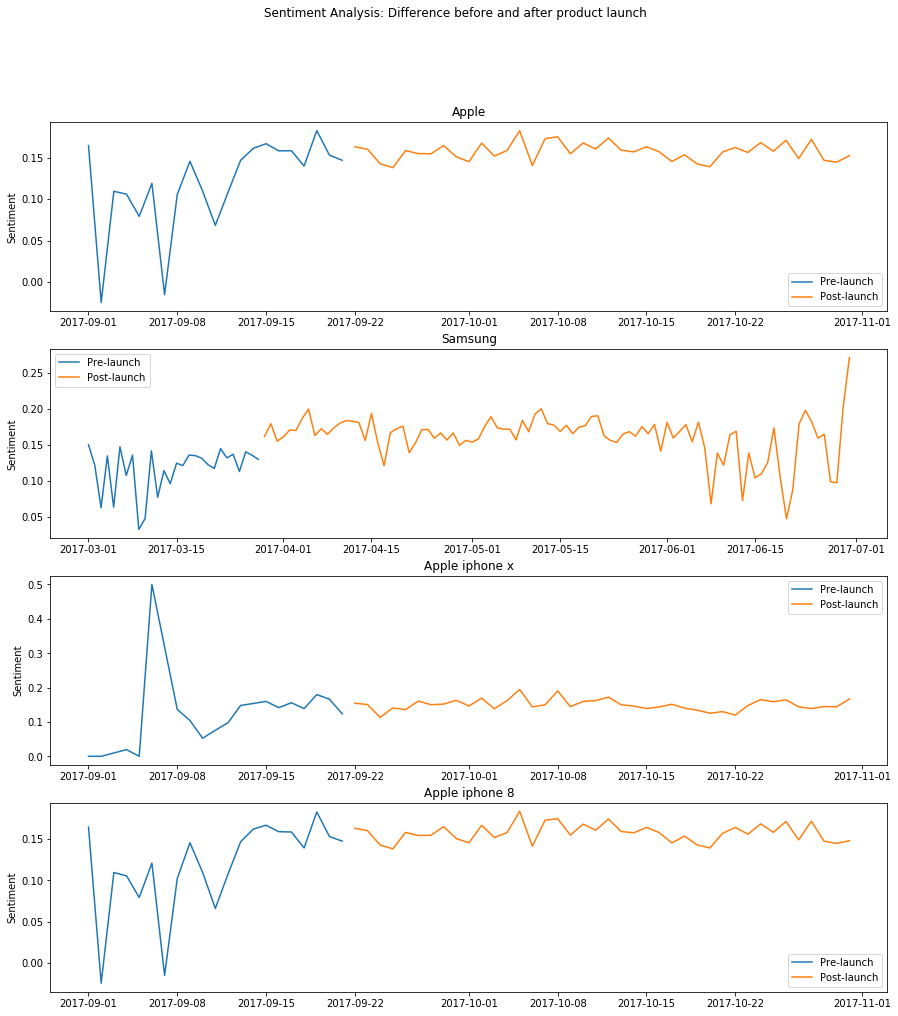

In [168]:
launch_df = product_sentiment_launch_diff(data_dict)
display_sentiment_launch_diff(launch_df)

## Get Sentiment from professionals and celebrities
(followers > 2000)

In [95]:
def product_sentiment_followers_diff(data_dict):
    
    diff_df = {}
    
    for product, data in data_dict.items(): 
        
        brand = str.split(product, ' ')[0]
        start, end = start_dates[brand], end_dates[brand]
        data = data[(data['Date'] >= start) & (data['Date'] <= end)]

        normal_df = data[data['No. of Followers/Daily Unique Visitors'] <= 2000]
        celebrity_df = data[data['No. of Followers/Daily Unique Visitors'] > 2000]

        print('Normal user sentiment for %s is %s' %(product, sum(normal_df['Sentiment'])/len(normal_df['Sentiment'])))
        print('Professionals and Celebrity sentiment for %s is %s' %(product, sum(celebrity_df['Sentiment'])/len(celebrity_df['Sentiment'])))

        diff_df.update({product : [normal_df, celebrity_df]})
    
    return diff_df

In [166]:
def display_sentiment_followers_diff(diff_df):
    
    num_prods = len(diff_df)
    labels = ('Normal Users', 'Professionals & Celebrities')
        
    fig, axes = plt.subplots(num_prods, 1, sharey='row', figsize=(15, 4*num_prods))
    fig.suptitle('Sentiment Analysis: Difference across users with different sizes of followers')
    i = 0
    for product, data in diff_df.items(): 
        axes[i].plot(data[0].groupby(['Date'])['Sentiment'].mean())
        axes[i].set(ylabel='Sentiment')
        axes[i].set_title(product.capitalize())
        axes[i].plot(data[1].groupby(['Date'])['Sentiment'].mean())
        axes[i].legend(labels)
        i += 1

Normal user sentiment for apple is 0.15646499801787664
Professionals and Celebrity sentiment for apple is 0.14498738261626865
Normal user sentiment for samsung is 0.1627532223329714
Professionals and Celebrity sentiment for samsung is 0.15425338300513772
Normal user sentiment for apple iphone x is 0.15095647015690425
Professionals and Celebrity sentiment for apple iphone x is 0.15994949284889956
Normal user sentiment for apple iphone 8 is 0.15662165085629667
Professionals and Celebrity sentiment for apple iphone 8 is 0.14490001717465298


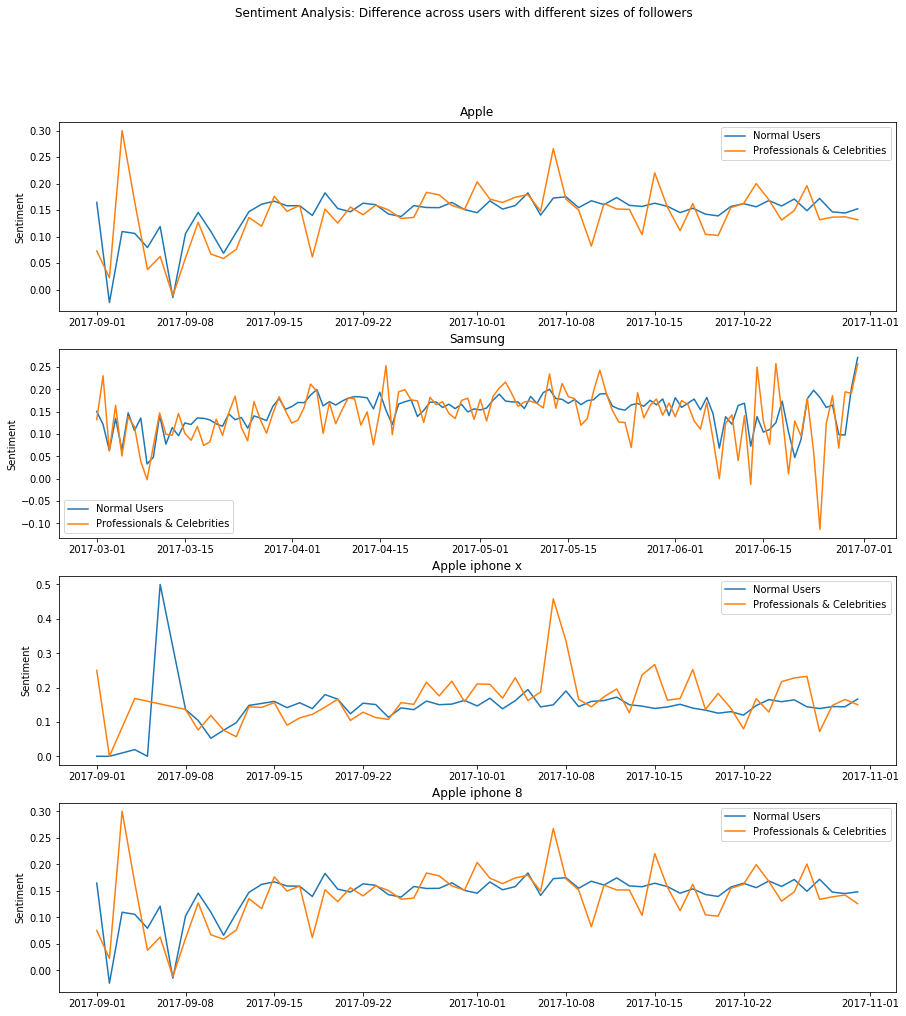

In [169]:
followers_diff_df = product_sentiment_followers_diff(data_dict)
display_sentiment_followers_diff(followers_diff_df)

## Get Sentiment from Female and Male

In [102]:
def product_sentiment_genders_diff(data_dict):
    
    diff_df = {}
    
    for product, data in data_dict.items(): 
        
        brand = str.split(product, ' ')[0]
        start, end = start_dates[brand], end_dates[brand]
        data = data[(data['Date'] >= start) & (data['Date'] <= end)]

        female_df = data[data['Author Gender'] == 'Female']
        male_df = data[data['Author Gender'] == 'Male']

        print('Female sentiment for %s is %s' %(product, sum(female_df['Sentiment'])/len(female_df['Sentiment'])))
        print('Male sentiment for %s is %s' %(product, sum(male_df['Sentiment'])/len(male_df['Sentiment'])))

        diff_df.update({product : [female_df, male_df]})
    
    return diff_df

In [145]:
def display_sentiment_genders_diff(diff_df):
    
    num_prods = len(diff_df)
    labels = ('Female', 'Male')
        
    fig, axes = plt.subplots(num_prods, 1, sharey='row', figsize=(15, 4*num_prods))
    fig.suptitle('Sentiment Analysis: Difference across genders')
    i = 0
    for product, data in diff_df.items(): 
        axes[i].plot(data[0].groupby(['Date'])['Sentiment'].mean())
        axes[i].set(ylabel='Sentiment')
        axes[i].set_title(product.capitalize())
        axes[i].plot(data[1].groupby(['Date'])['Sentiment'].mean())
        axes[i].legend(labels)
        i += 1

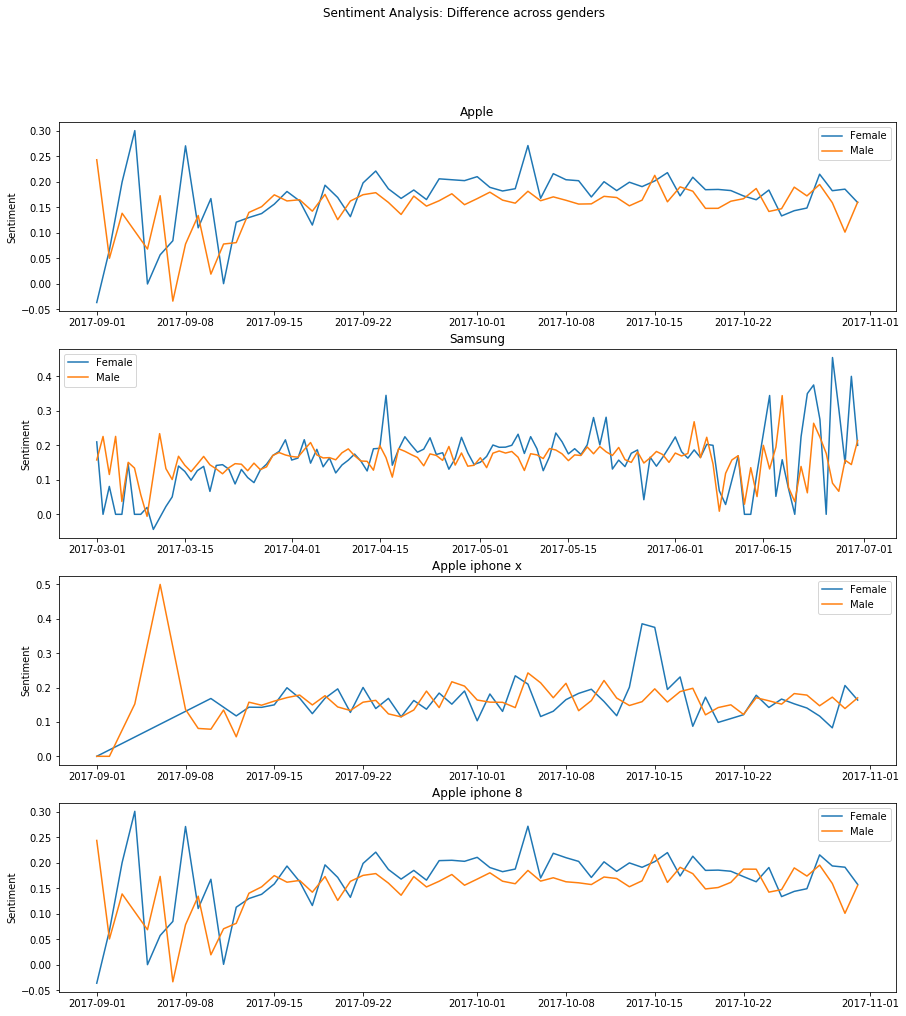

In [146]:
genders_diff_df = product_sentiment_genders_diff(data_dict)
display_sentiment_genders_diff(genders_diff_df)

## Get Sentiment across twitter / non-twitter platforms

In [105]:
def product_sentiment_platforms_diff(data_dict):
    
    diff_df = {}
    
    for product, data in data_dict.items(): 
        
        brand = str.split(product, ' ')[0]
        start, end = start_dates[brand], end_dates[brand]
        data = data[(data['Date'] >= start) & (data['Date'] <= end)]

        twitter_df = data[data['Source Type']=='Twitter']
        nontwitter_df = data[data['Source Type']!='Twitter']

        print('Twitter sentiment for %s is %s' %(product, sum(twitter_df['Sentiment'])/len(twitter_df['Sentiment'])))
        print('Non-Twitter sentiment for %s is %s' %(product, sum(nontwitter_df['Sentiment'])/len(nontwitter_df['Sentiment'])))

        diff_df.update({product : [twitter_df, nontwitter_df]})
    
    return diff_df

In [167]:
def display_sentiment_platforms_diff(diff_df):
    
    num_prods = len(diff_df)
    labels = ('Twitter', 'Non-Twitter')
        
    fig, axes = plt.subplots(num_prods, 1, sharey='row', figsize=(15, 4*num_prods))
    fig.suptitle('Sentiment Analysis: Difference across platforms')
    i = 0
    for product, data in diff_df.items(): 
        axes[i].plot(data[0].groupby(['Date'])['Sentiment'].mean())
        axes[i].set(ylabel='Sentiment')
        axes[i].set_title(product.capitalize())
        axes[i].plot(data[1].groupby(['Date'])['Sentiment'].mean())
        axes[i].legend(labels)
        i += 1

Twitter sentiment for apple is 0.13166419830890727
Non-Twitter sentiment for apple is 0.15681275316271734
Twitter sentiment for samsung is 0.14093329616449657
Non-Twitter sentiment for samsung is 0.1645760550848227
Twitter sentiment for apple iphone x is 0.16517696004117124
Non-Twitter sentiment for apple iphone x is 0.15116190144625696
Twitter sentiment for apple iphone 8 is 0.13162180630145012
Non-Twitter sentiment for apple iphone 8 is 0.15696796554786746


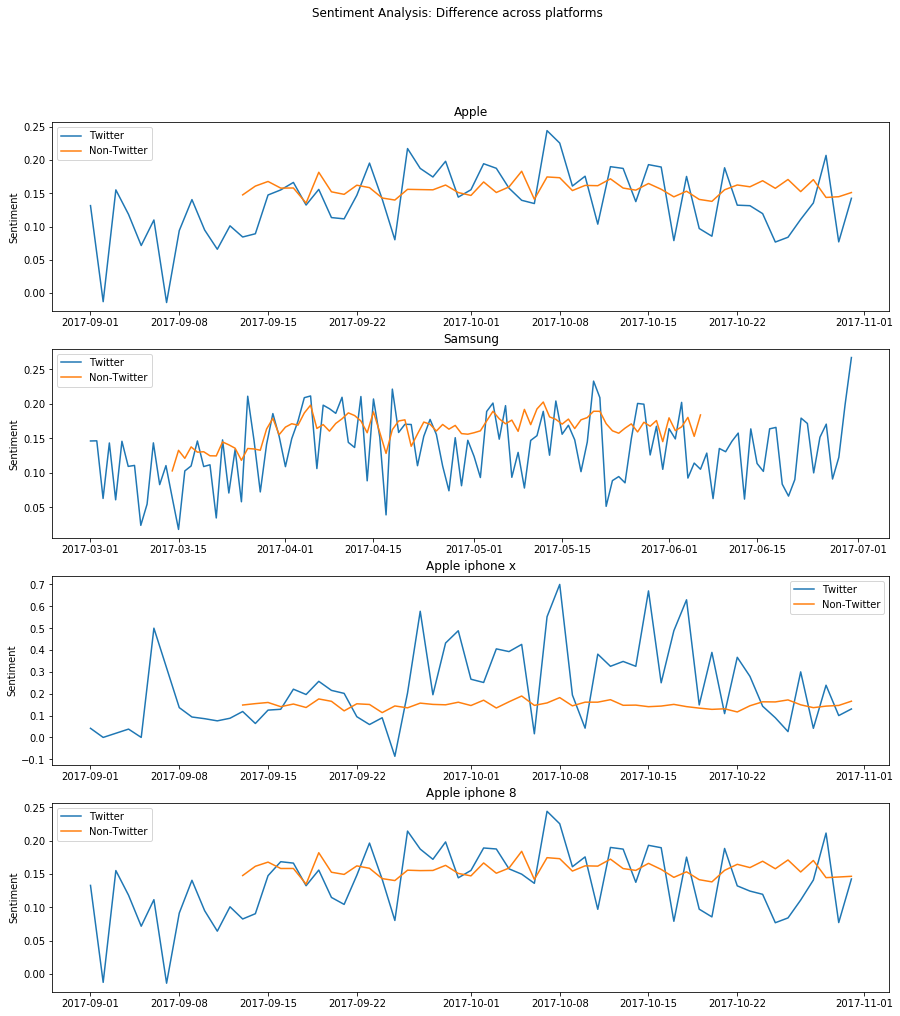

In [170]:
platform_diff_df = product_sentiment_platforms_diff(data_dict)
display_sentiment_platforms_diff(platform_diff_df)

## Sentiment on different Media Type

In [108]:
apple_sentiment_media_type = apple_data.groupby('Media Type').filter(lambda x : len(x) > 100).groupby('Media Type')['Sentiment'].mean()
samsung_sentiment_media_type = samsung_data.groupby('Media Type').filter(lambda x : len(x) > 100).groupby('Media Type')['Sentiment'].mean()
apple_sentiment_media_type = apple_sentiment_media_type.sort_values(ascending = False)
samsung_sentiment_media_type = samsung_sentiment_media_type.sort_values(ascending = False)

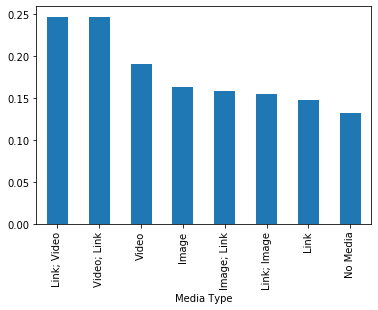

In [115]:
apple_sentiment_media_type.plot(kind='bar')

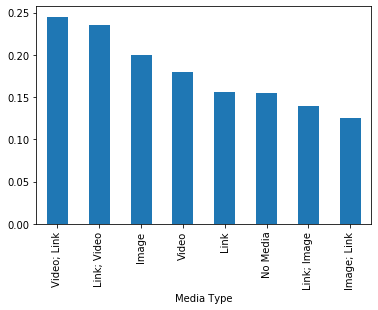

In [116]:
samsung_sentiment_media_type.plot(kind='bar')

## WordCloud for good and bad sentiment

In [139]:
stopwords = spacy.lang.en.stop_words.STOP_WORDS
stopwords.add('iphone')
stopwords.add('samsung')
stopwords.add('PRON')
stopwords.add('apple')
stopwords.add('plus')
stopwords.add('phone')
stopwords.add('8')
stopwords.add('x')
stopwords.add('s')
stopwords.add('t')
stopwords.add('ift')
stopwords.add('tt')
stopwords.add('http')
stopwords.add('galaxy')
stopwords.add('smartphone')
stopwords.add('s7')
stopwords.add('s8')
stopwords.add('lg')
stopwords.add('g6')
stopwords.add('https')
stopwords.add('Twitter')
stopwords.add('pic twitter')
stopwords.add('Tags')
stopwords.add('IFTTT')
stopwords.add('Tags IFTTT')
stopwords.add('com')
stopwords.add('ha')
stopwords.add('galaxys8')
stopwords.add('galaxys8plus')
stopwords.add('samsunggalaxys8')
stopwords.add('samsunggalaxys')
stopwords.add('samsunggalaxys8plus')
stopwords.add('samsunggalaxy8')
stopwords.add('galaxys8plus')
stopwords.add('iphone8')
stopwords.add('iphone8plus')
stopwords.add('pici')
stopwords.add('tk')

In [123]:
def extract_keywords(text_list):
    good_list, bad_list = [], []
    for i in range(len(text_list)):
        # create TextBlob object of passed tweet text 
        text = text_list[i]
        analysis = TextBlob(clean_text(text)) 
        # set sentiment 
        sent = analysis.sentiment.polarity
        words = analysis.words

        # add the lemma of the word
        if sent > 0.3:
            for w in words:
                good_list.append(w.lemmatize())
        elif sent < -0.3:
            for w in words:
                bad_list.append(w.lemmatize())
#     debug
#     print(len(good_list), len(bad_list))
    return good_list, bad_list

In [143]:
def display_wordcloud(wc_dict):
    products = ['apple', 'samsung']
    senses = ['good', 'bad']
    fig, axes = plt.subplots(2,2,figsize=(20,20)) 
    for i in range(2):
        p = products[i]
        mask_path = p + '.png'
        mask = skimage.io.imread(mask_path)
        for j in range(2):
            word_cloud = WordCloud(width=2000, height=1000, max_font_size=200, 
                    background_color="black", stopwords=stopwords, max_words=2000,
                    contour_width=1, contour_color="steelblue",
                    colormap="nipy_spectral").generate(' '.join(wc_dict[p][j]))
            axes[i][j].imshow(word_cloud, interpolation="hermite")
            axes[i][j].set_title('Word Cloud for %s with %s sentiment' % (p.capitalize(), senses[j]))
            axes[i][j].axis("off")
    plt.show() 

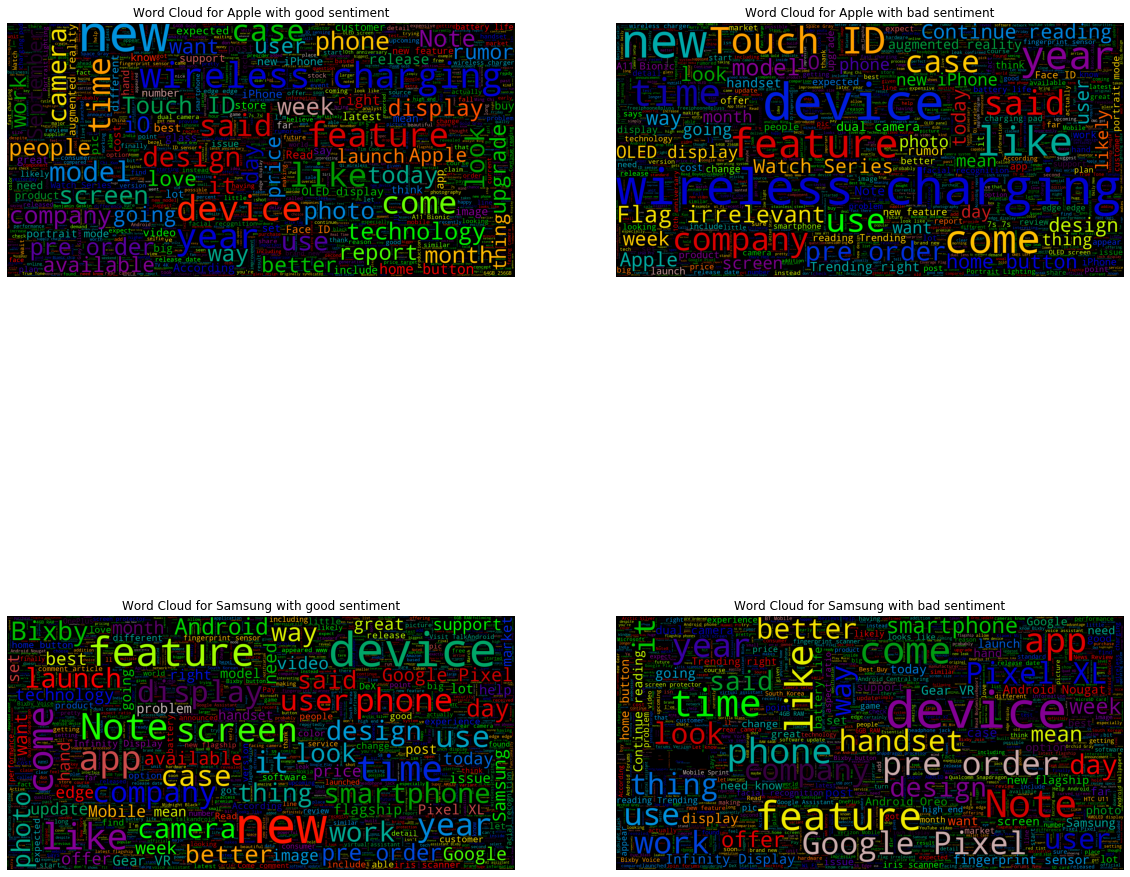

In [144]:
display_wordcloud({'apple':[list(apple_data[apple_data['Author Gender']=='Female']['Sound Bite Text']), 
                            list(apple_data[apple_data['Author Gender']=='Male']['Sound Bite Text'])], 
                   'samsung':[list(samsung_data[samsung_data['Author Gender']=='Female']['Sound Bite Text']), 
                            list(samsung_data[samsung_data['Author Gender']=='Male']['Sound Bite Text'])]})

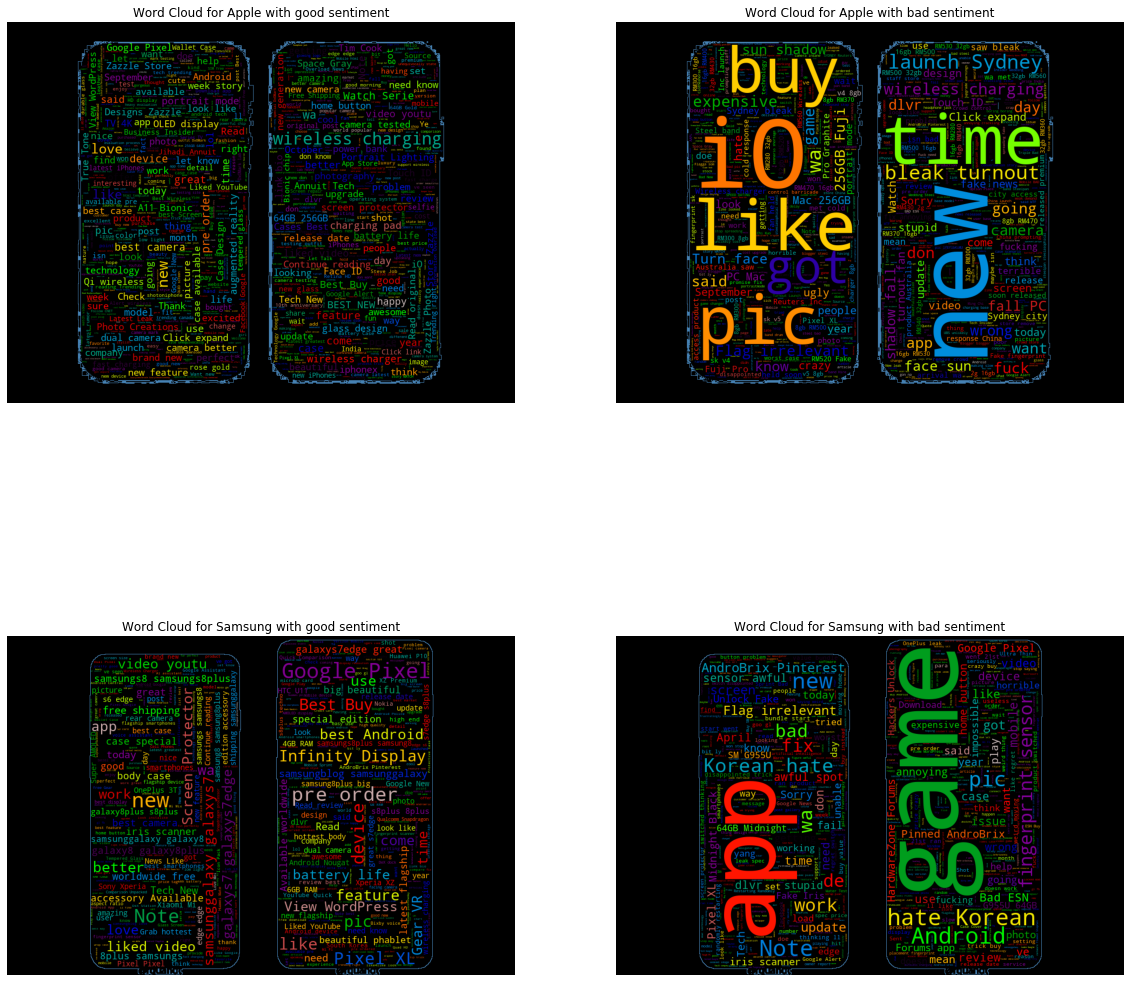

In [141]:
samsung_good, samsung_bad = extract_keywords(list(samsung_data['Sound Bite Text']))
apple_good, apple_bad = extract_keywords(list(apple_data['Sound Bite Text']))
display_wordcloud({'apple':[apple_good, apple_bad], 'samsung':[samsung_good, samsung_bad]})

## Time Series

In [126]:
def extract_time_series_data(data, prod):
    # use only normal users
#     data[data['No. of Followers/Daily Unique Visitors'] > 2000]
    
    # get those only for samsung
#     data = data[data['Sound Bite Text'].str.contains('|'.join(kw_dict[prod]), case=False)]
    
    # keep only 'Date' and 'Sentiment'
    data = data[['Date', 'Sentiment']]
    
    # prelaunch df will be our training data
    start, end = start_dates[prod], end_dates[prod]
    data = data[(data['Date'] >= start) & (data['Date'] <= end)]
    data = data.groupby('Date')['Sentiment'].mean().reset_index()
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.set_index('Date')
    
    return data

In [127]:
#Time Series Dataframe
tsdf_apple = extract_time_series_data(apple_data, 'apple')
tsdf_samsung = extract_time_series_data(samsung_data, 'samsung')

In [128]:
def display_seasonal_decompose(data):
    rcParams['figure.figsize'] = 18, 8
    decomposition = sm.tsa.seasonal_decompose(data, model='additive')
    fig = decomposition.plot()
    plt.show()

In [129]:
def fit_ARIMA_model(data, prod):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    minAIC = np.inf
    best_param = {}

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                if results.aic < minAIC:
                    minAIC = results.aic
                    best_param['order'] = param
                    best_param['seasonal_order'] = param_seasonal
#                 print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue

    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=best_param['order'],
                                    seasonal_order=best_param['seasonal_order'],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)
    results = mod.fit()

    results.plot_diagnostics(figsize=(16, 8))
    plt.title('ARIMA Model Diagnostics for %s' % prod.capitalize())
    plt.show()
    
    return results

In [130]:
def predict_post_launch(results, data, product):
    lcdate = lc_dates[product]
    pred = results.get_prediction(start=pd.to_datetime(lcdate), dynamic=False)
    pred_ci = pred.conf_int()
#     debug
#     print(pred_ci)
    ax = data[:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment')
    plt.title('Post-launch prediction for %s' % product.capitalize())
    plt.legend(loc='lower right')
    plt.show()

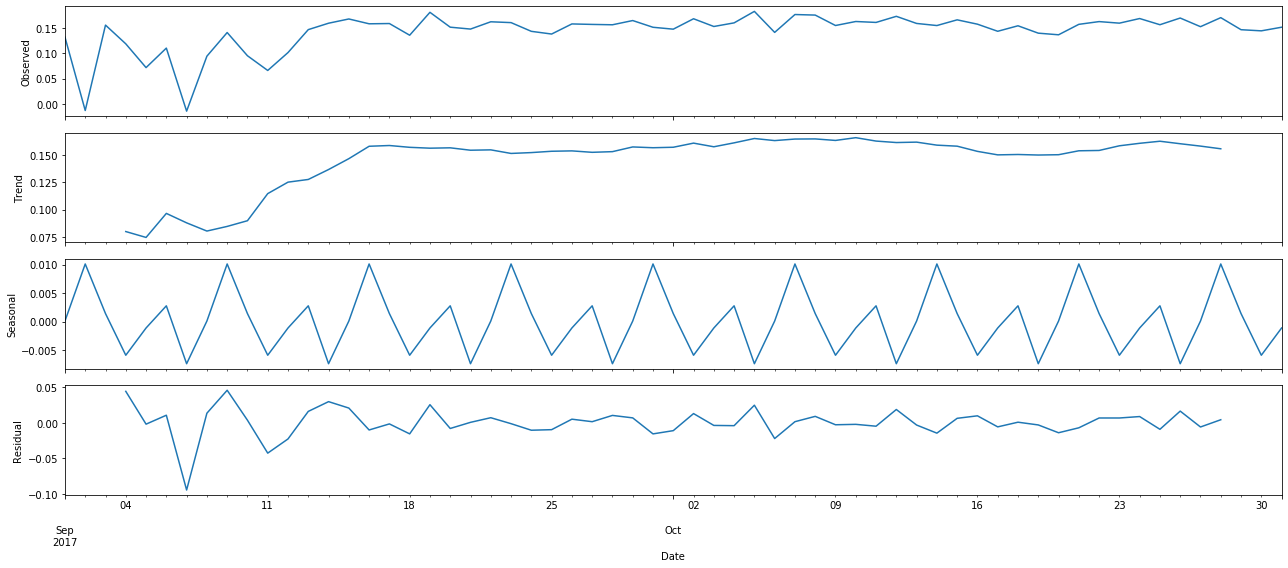

In [131]:
display_seasonal_decompose(tsdf_apple)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packa

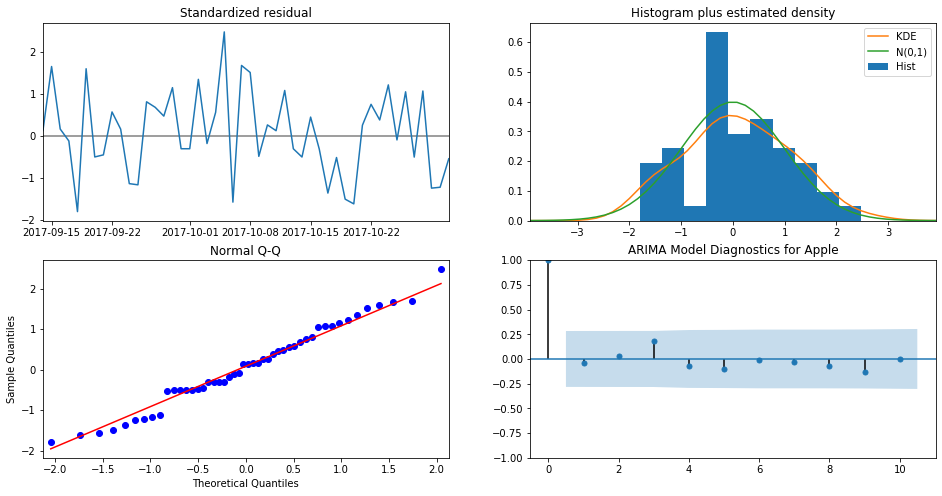

In [132]:
results = fit_ARIMA_model(tsdf_apple, 'apple')

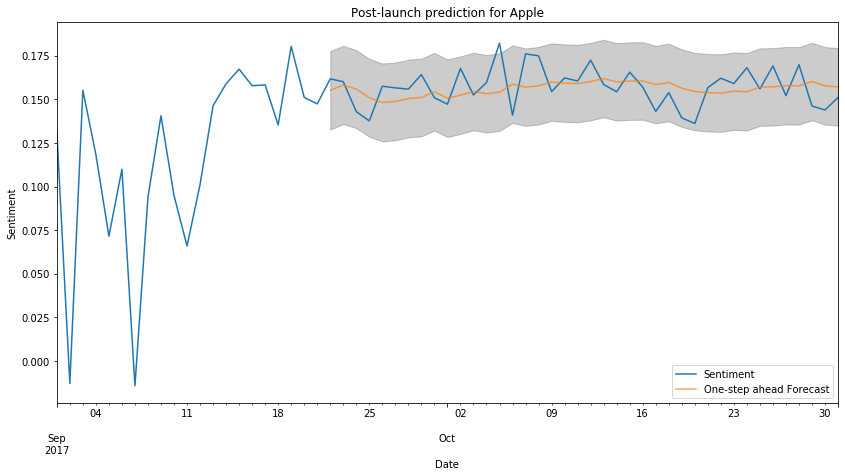

In [133]:
predict_post_launch(results, tsdf_apple, 'apple')

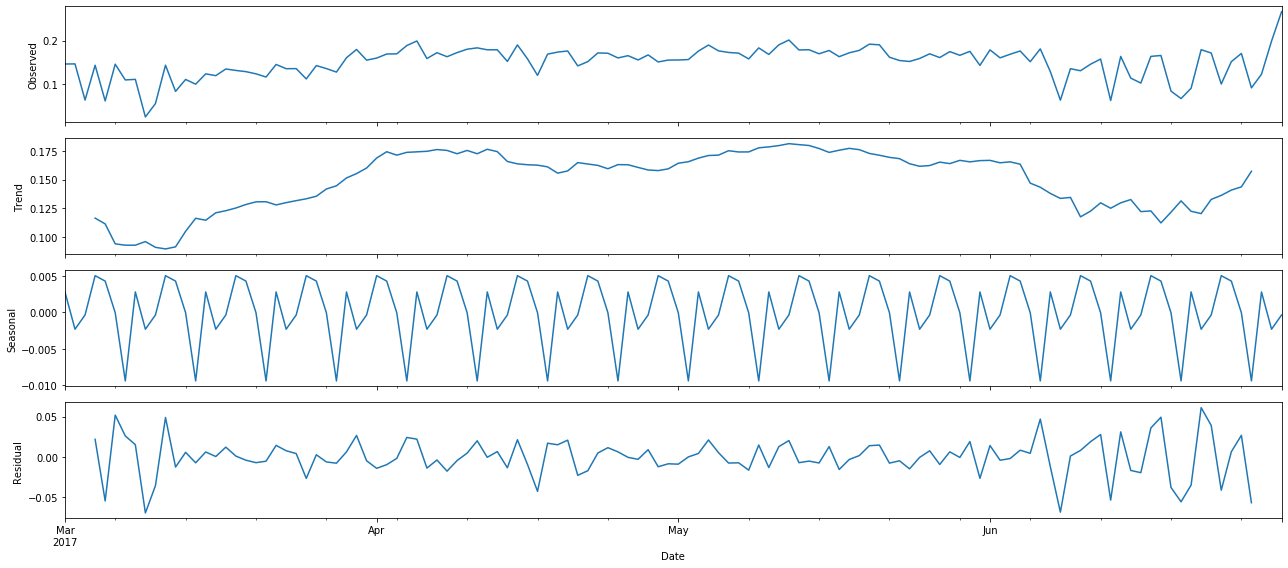

In [134]:
display_seasonal_decompose(tsdf_samsung)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packa

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packa

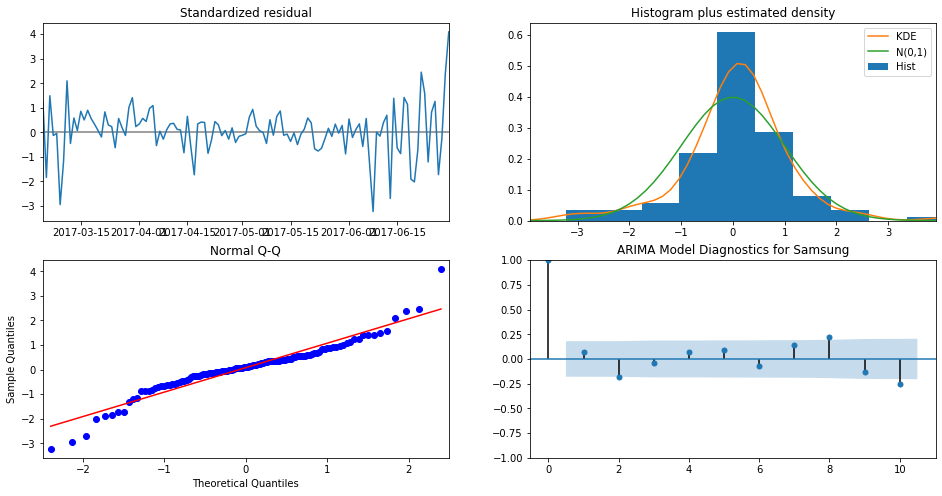

In [135]:
results = fit_ARIMA_model(tsdf_samsung, 'samsung')

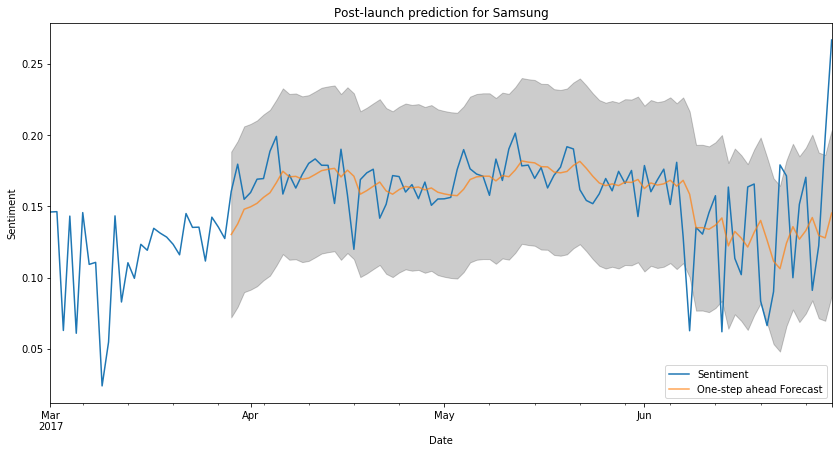

In [136]:
predict_post_launch(results, tsdf_samsung, 'samsung')